Created this file for cleaner start. The first file (micrograd.ipynb) was used for derivation and stuff.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
class Value:  # we have created this class sort of an analogy for tensors. Just to manipulate the whole training process with some data structure
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # initialized to 0 as we assume that by default no node or weight affects the loss function. This is the derivative of loss function w.r.t. that node
        self._prev = set(_children) # this is used to keep track of the previous nodes in the graph
        self._backward = lambda: None  # this would be a function that would differ for all the different operators
        self._op = _op
        self.label = label
    
    def __repr__(self): # magic function to print the object. Can modify the string representation of the object when printed.
        return f"Value(data={self.data})"
    
    def __add__(self, other): # magic function to add two objects. Can modify the behavior of the + operator when applied to objects of this class. In case of a.__add__(b), a is self and b is other.
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), '+')
        def _backward(): # we want to take out grad and find out the self grad and other grad, so we will set self.grad to something and other.grad to something
            self.grad += 1.0 * out.grad # local derivative * global derivative
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
            
    def __mul__(self, other): # magic function to multiply two objects. Can modify the behavior of the * operator when applied to objects of this class. In case of a.__mul__(b), a is self and b is other.
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad # local derivative * global derivative
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
             self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self): # -self
        return self * (-1)
    
    def __sub__(self, other): # self - other
        return self + (-other)
        
    def __truediv__(self, other): # self/other
        return self * (other ** -1)
    
    def __radd__(self, other): # other + self
        return self + other
        
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad # local derivative * global derivative
        out._backward = _backward
        return out
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0 # base condition
        for node in reversed(topo):
            node._backward()

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data:%.4f | grad:%.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

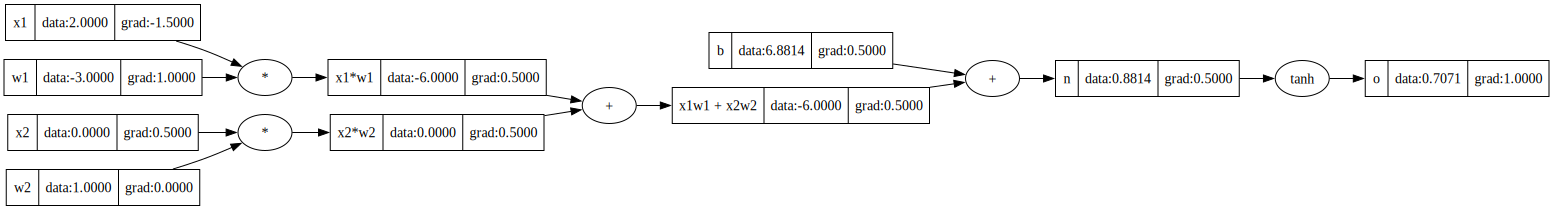

In [4]:
# building a basic neuron
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# constant or bias
b = Value(6.8813735870195432, label='b') # just to get good numbers in output, setting this value
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

o.backward()
draw_dot(o)

Now we will use pytorch framework to confirm our backward progapagation values that we got using micrograd

In [5]:
import torch

In [6]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True  # python by default uses double float integer types, so converting it to double to make everything consistent  
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # forward pass for o
o.backward()

print('_______')
print("x1 grad:", x1.grad.item())
print("w1 grad:", w1.grad.item())
print("x2 grad:", x2.grad.item())
print("w2 grad:", w2.grad.item())



0.7071066904050358
_______
x1 grad: -1.5000003851533106
w1 grad: 1.0000002567688737
x2 grad: 0.5000001283844369
w2 grad: 0.0


Now we will build our own two layered MLP from scratch. For that, we will build a neuron class first.

In [7]:
class Neuron:
    
    def __init__(self, nin): # nin: number of inputs
        # initialize weights and bias
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):  # magic function to make the class object callable. Ex n = Neuron(), then we can call n(2)
        # forward pass: w *  x + b
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b   # raw activation
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [8]:
class Layer:
    
    def __init__(self, nin, nout): # nin: number of inputs for each neuron, nout: number of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        # we have to call neuron(x) for each neuron object
       outs = [n(x) for n in self.neurons]
       return outs[0] if len(outs) == 1 else outs
   
    def parameters(self):
       return [p for neuron in self.neurons for p in neuron.parameters()] # list comprehension for the commented code
    #    for neuron in self.neurons:
    #        ps = neuron.parameters()
    #        params.extend(ps)
    #     return params 

In [9]:
class MLP:
    
    def __init__(self, nin, nouts): # nin: number of inputs; nouts: size of each layer or no. of neurons in each layer. nouts is a list
        sizes = [nin] + nouts # since, for the first layer, the input will go directly for the next layer, output of the previous layer would be the input. Hence, adding nin to sizes with nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # output of the previous layer is input to the next layer
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        # params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params

In [10]:
x = [-2.0, 4.0, 1]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=0.4841508722362814)

In [11]:
len(n.parameters())
# draw_dot(n(x))

41

In [12]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1,0, 0.5],
    [-4.0, 0.5, 0],
    [-1.0, -2.0, 4.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # simulating a basic binary classification. These are ground truth

ypred = [n(x) for x in xs]
ypred # predictions after just one forward pass

[Value(data=0.5109564441487823),
 Value(data=0.9533538738861984),
 Value(data=0.6417285493289414),
 Value(data=0.9180172243798411)]

In [13]:
# calculating loss (mean squared error)
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# loss

In [14]:
# loss.backward()

In [15]:
# n.layers[0].neurons[0].w[0].grad

Basic steps to follow to train any neural network are:
1. Forward Pass
2. Backward Pass (we also flush the gradients to zero before the backward pass so that we do not keep on accumulating the gradients as by default they keep on adding)
3. Update weights (using gradient descent)

In [16]:
steps = 1000
lr = 0.005
n = MLP(3, [4, 4, 1]) # definition of the architecture
for k in range(steps):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters(): # making the grads zero so that gradients do not keep on accumulating on every step.
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -lr * p.grad # gradient descent
    
    print(f"{k}, loss: {loss.data}")    
    

0, loss: 7.094052887503457
1, loss: 7.0382409562991395
2, loss: 6.976989453259534
3, loss: 6.909762019463831
4, loss: 6.836023255951915
5, loss: 6.755271029370838
6, loss: 6.667083543436086
7, loss: 6.571183653854994
8, loss: 6.467520680480008
9, loss: 6.356365441085545
10, loss: 6.238406958312895
11, loss: 6.1148300268252145
12, loss: 5.9873445740710585
13, loss: 5.858136143405313
14, loss: 5.729718310470841
15, loss: 5.604694734970032
16, loss: 5.485473438983873
17, loss: 5.374001539077723
18, loss: 5.271587843059746
19, loss: 5.178850531220713
20, loss: 5.095783491781082
21, loss: 5.021900917411219
22, loss: 4.956409001201527
23, loss: 4.898363508017615
24, loss: 4.846790948890476
25, loss: 4.800768292677793
26, loss: 4.759466714859188
27, loss: 4.72216895819054
28, loss: 4.688269776619725
29, loss: 4.6572669693650495
30, loss: 4.628748187725486
31, loss: 4.602376717614025
32, loss: 4.577878003729548
33, loss: 4.555027743132365
34, loss: 4.533641815198167
35, loss: 4.513568009404666

In [17]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9994581364104314),
 Value(data=-0.944768099759621),
 Value(data=-0.952780984981874),
 Value(data=0.9501517670226062)]